In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
   
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        image_size = (gray.shape[1], gray.shape[0])
        offset = 100
        src = np.float32([corners[0], 
                        corners[nx-1], 
                        corners[-1], 
                        corners[-nx]])
        
        dst = np.float32([[offset, offset],
                        [image_size[0]-offset, offset],
                        [image_size[0]-offset, image_size[1]-offset],
                        [offset, image_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(gray, M, image_size)
        
    return warped, M

In [3]:
def corners_unwarp(nx, ny):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    paths = os.getcwd()+'/camera_cal'
    files = os.listdir(paths)

    for num, fname in enumerate(files):

        img = mpimg.imread('./camera_cal/'+fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            retur, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

            origin = np.copy(img)
            draw_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

            undist = cv2.undistort(img, mtx, dist, None, mtx)
            gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            image_size = (gray.shape[1], gray.shape[0])
            offset = 100
            src = np.float32([corners[0], 
                            corners[nx-1], 
                            corners[-1], 
                            corners[-nx]])

            dst = np.float32([[offset, offset],
                            [image_size[0]-offset, offset],
                            [image_size[0]-offset, image_size[1]-offset],
                            [offset, image_size[1]-offset]])
            M = cv2.getPerspectiveTransform(src,dst)
            unwarped = cv2.warpPerspective(gray, M, image_size)

            fig, axs = plt.subplots(1, 3, figsize=(15, 20))
            fig.tight_layout()

            axs[0].imshow(origin)
            axs[0].set_title("ORIGINAL_IMAGE " + fname.split('.')[0])
            axs[1].imshow(draw_corners)
            axs[1].set_title("CALIBRATE_IMAGE " + fname.split('.')[0])
            axs[2].imshow(unwarped)
            axs[2].set_title("UNWARPED_IMAGE " + fname.split('.')[0])

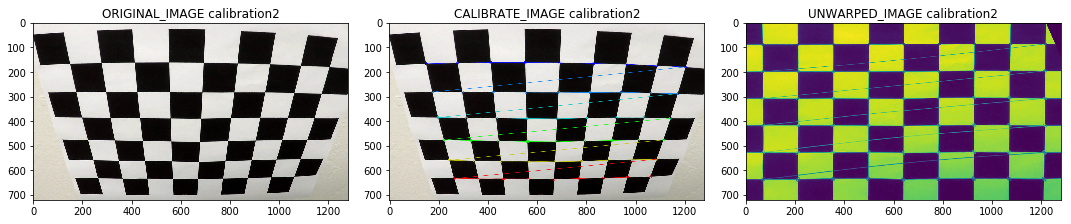

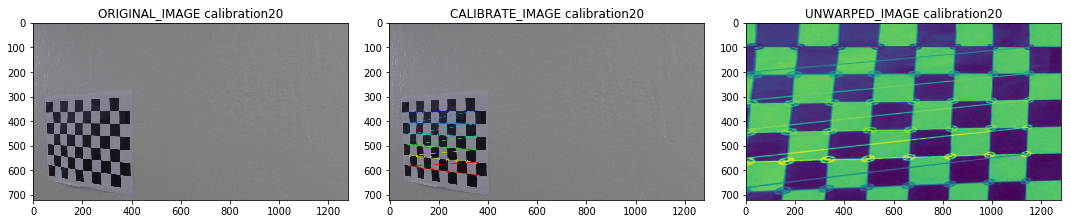

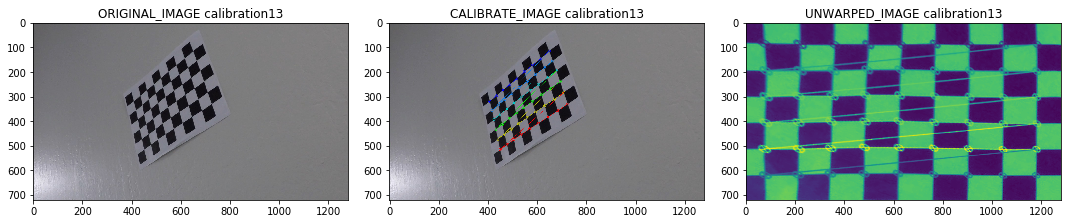

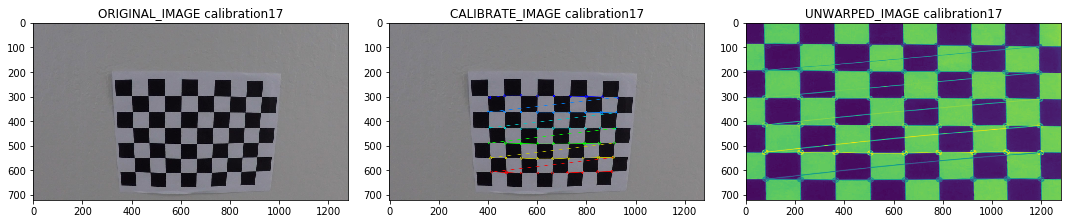

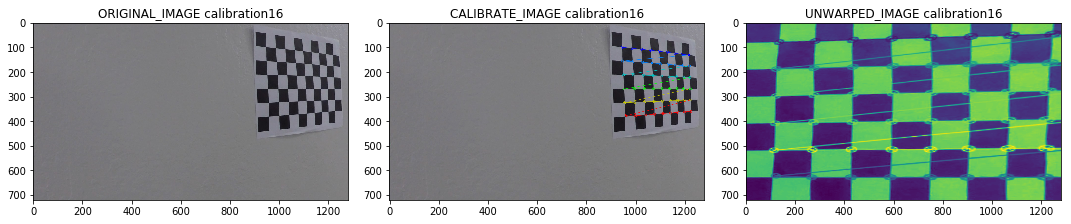

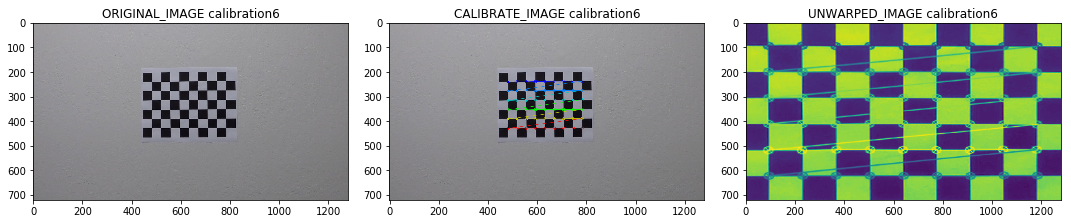

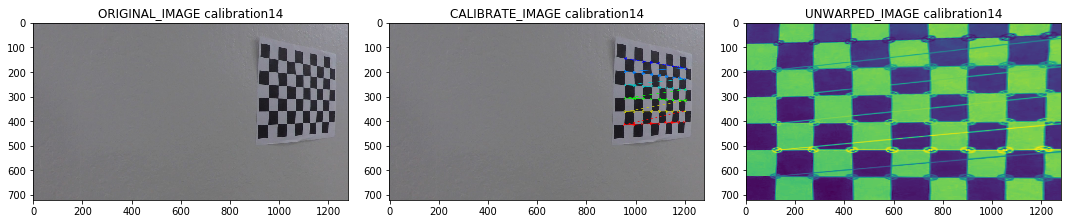

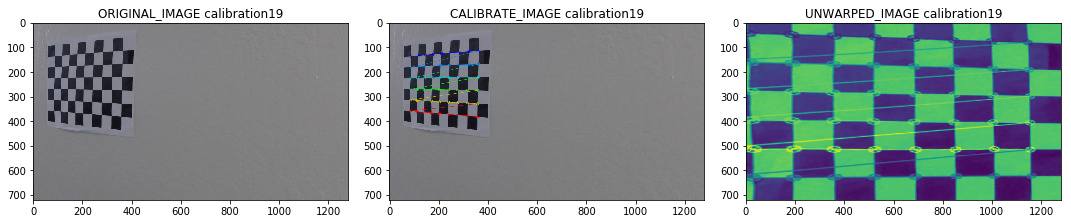

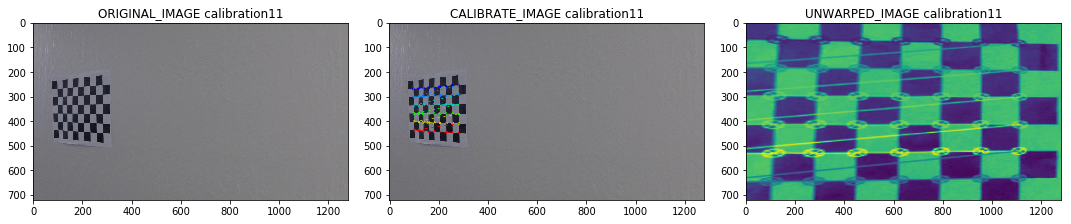

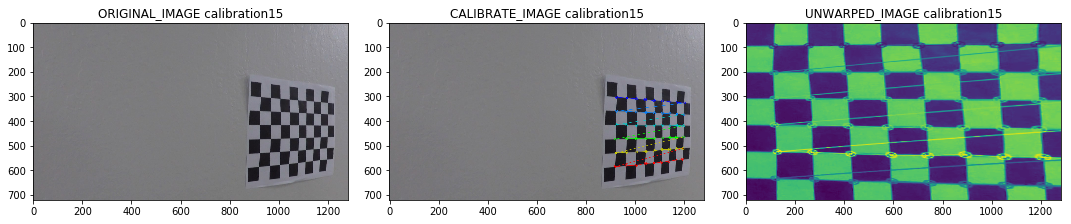

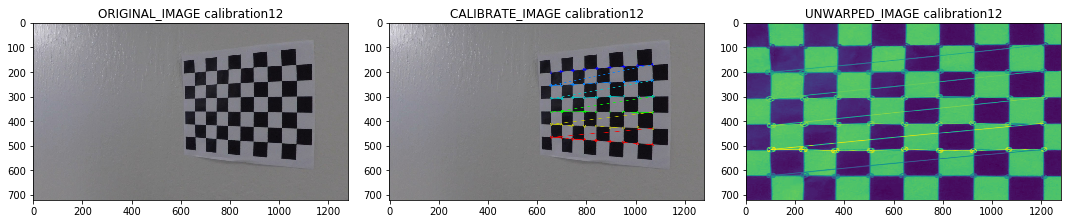

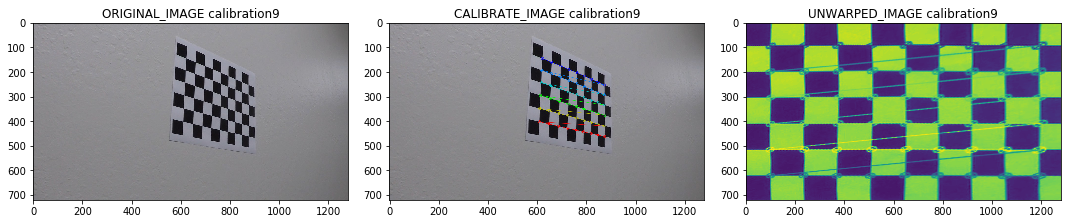

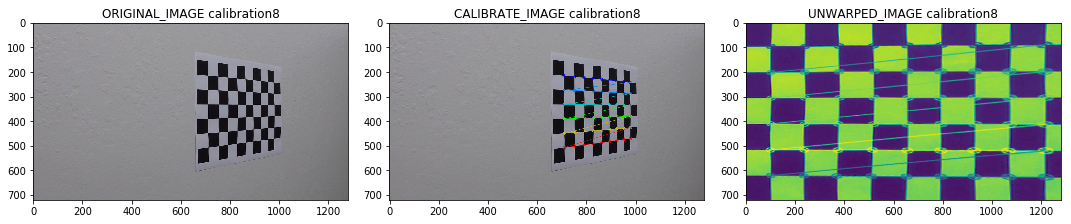

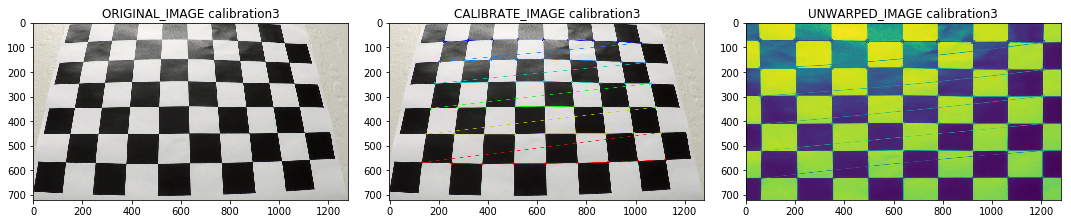

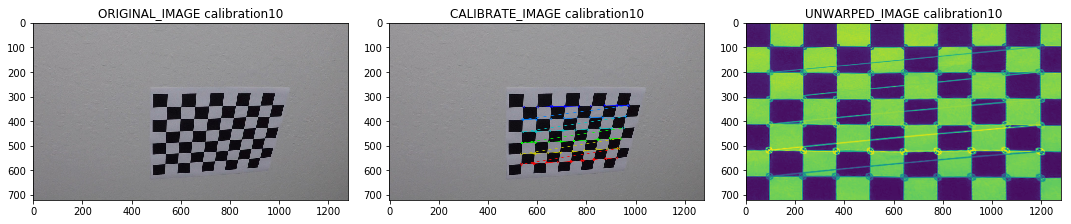

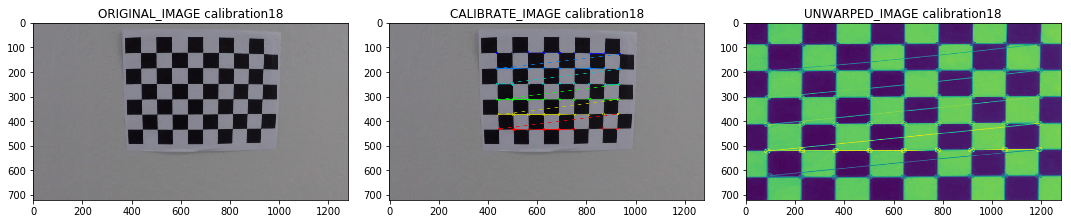

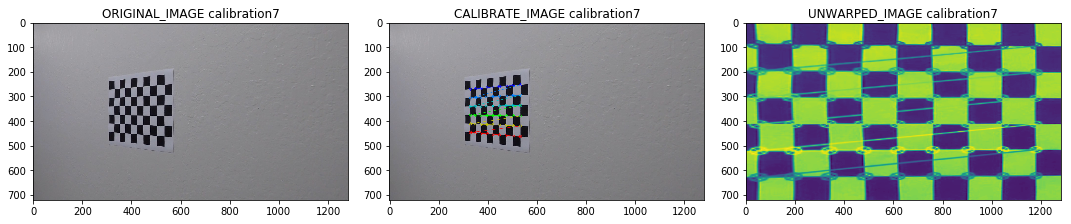

In [4]:
corners_unwarp(9, 6)

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    cal = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(cal)/255
    cal = (cal/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(cal)
    binary_output[(cal >= mag_thresh[0]) & (cal <= mag_thresh[1])] = 1
    return binary_output

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    atan = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(atan)
    binary_output[(atan >= thresh[0]) & (atan <= thresh[1])] = 1
    return binary_output

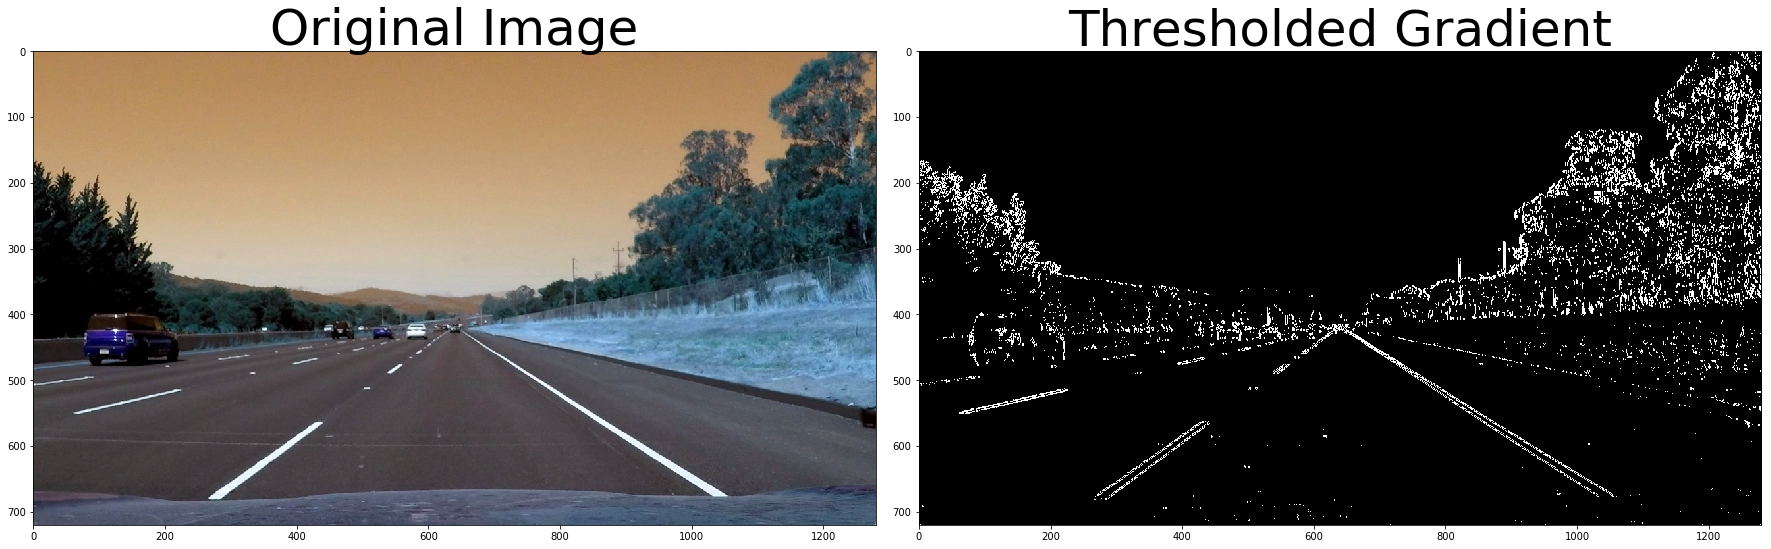

In [9]:
image = './test_images/straight_lines2.jpg'
img = cv2.imread(image)
ksize = 3 

grad_binary_x = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
grad_binary_y = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

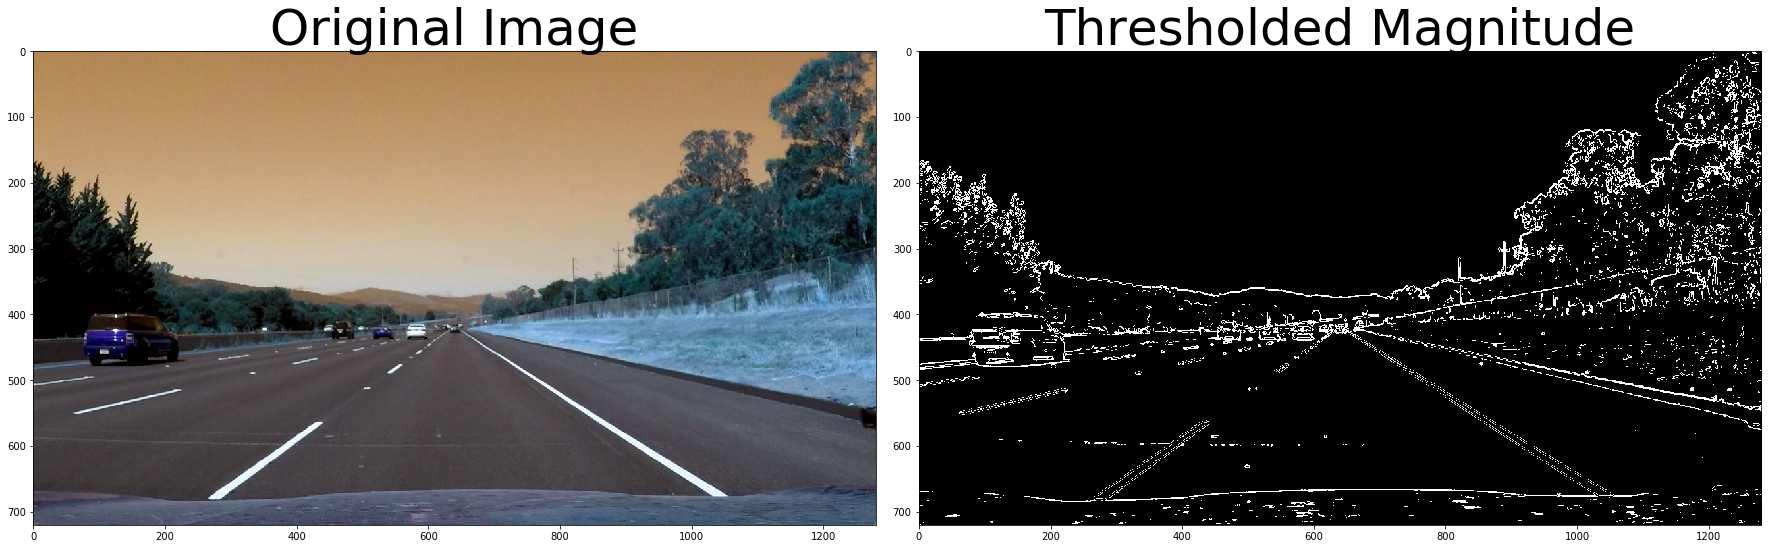

In [10]:
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

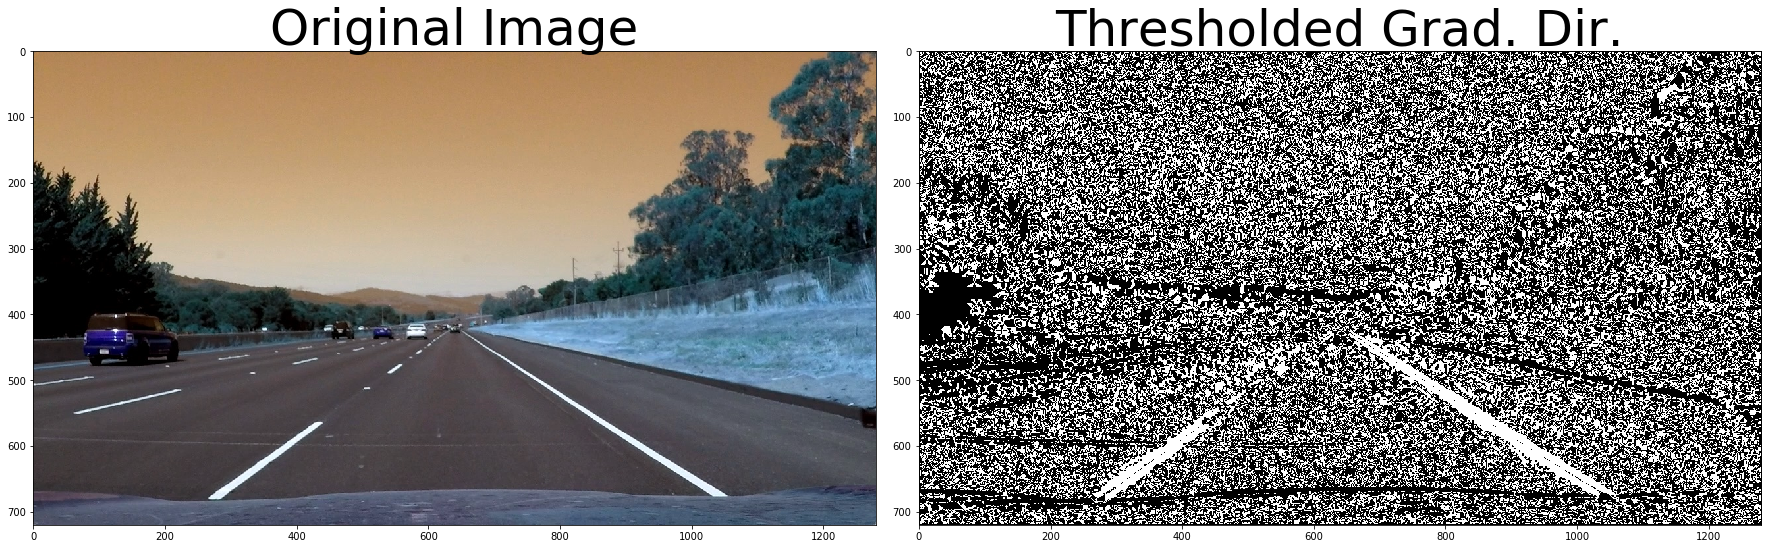

In [11]:
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

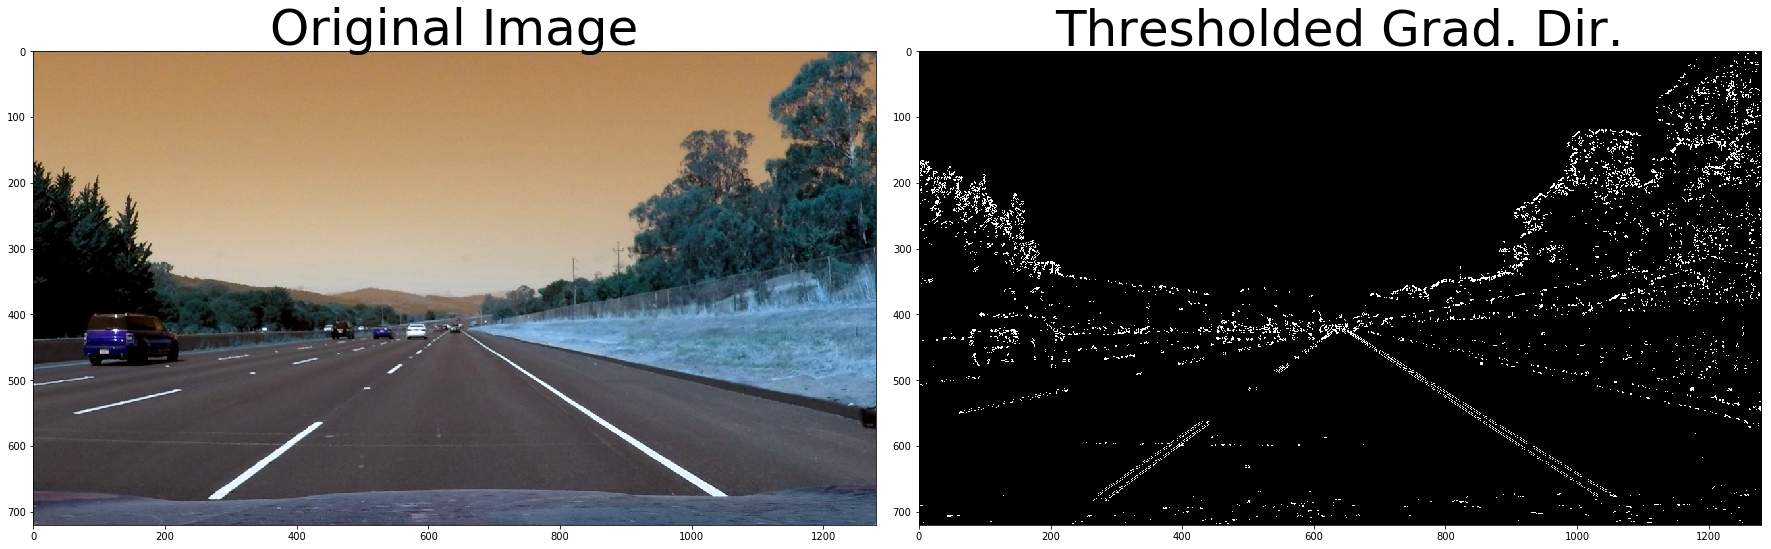

In [12]:
combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)